In [ ]:
# 1. ENVIRONMENT SETUP
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

!apt-get install -y libopenmpi-dev
!pip install mpi4py
!pip install datasets einops
!pip install torchmetrics torch-fidelity
!pip install blobfile
!git clone https://github.com/openai/guided-diffusion.git
%cd guided-diffusion
!pip install -e .
%cd ..

import sys
sys.path.append(os.path.abspath("./guided-diffusion"))

# 2. IMPORTS
import copy
import gc
import json
import random
import shutil
import time
import urllib.request
from dataclasses import dataclass, asdict
from typing import List, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchmetrics.image.fid import FrechetInceptionDistance
from datasets import load_dataset

from guided_diffusion import script_util

# 3. DEVICE CHECK
print("CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopenmpi-dev is already the newest version (4.1.2-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
fatal: destination path 'guided-diffusion' already exists and is not an empty directory.
/content/guided-diffusion
Obtaining file:///content/guided-diffusion
  Preparing metadata (setup.py) ... done
  Attempting uninstall: guided-diffusion
    Found existing installation: guided-diffusion 0.0.0
    Uninstalling guided-diffusion-0.0.0:
      Successfully uninstalled guided-diffusion-0.0.0
  Running setup.py develop for guided-diffusion
/content
CUDA: True
GPU: NVIDIA A100-SXM4-40GB


=== CONFIG ===
Steps: 1000 | Lambda: 0.002 | Ramp: 1000
Loading Dataset...
Dataset Size: 1000 images.
Loading pretrained weights...
Weights loaded.
Starting new run — deleting old checkpoint.
Phase 1: Warming up Discriminator with frozen Generator...
   Keeping D backbone frozen...


D Warm-up:   0%|          | 0/500 [00:00<?, ?it/s]


Phase 1 Complete!
   Final D scores — Real: 0.805, Fake: 0.180


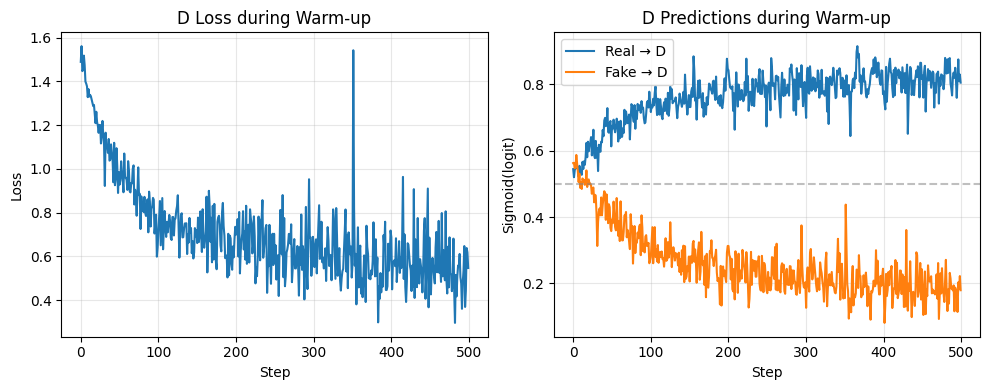


Memory cleaned. Free GPU: 31.42 GB
Ready for Phase 2...

Starting training for 1000 steps...


  0%|          | 0/1000 [00:00<?, ?it/s]

Training complete.

Generating comparison images...
Sampling pretrained model...


  0%|          | 0/50 [00:00<?, ?it/s]

Sampling fine-tuned model...


  0%|          | 0/50 [00:00<?, ?it/s]

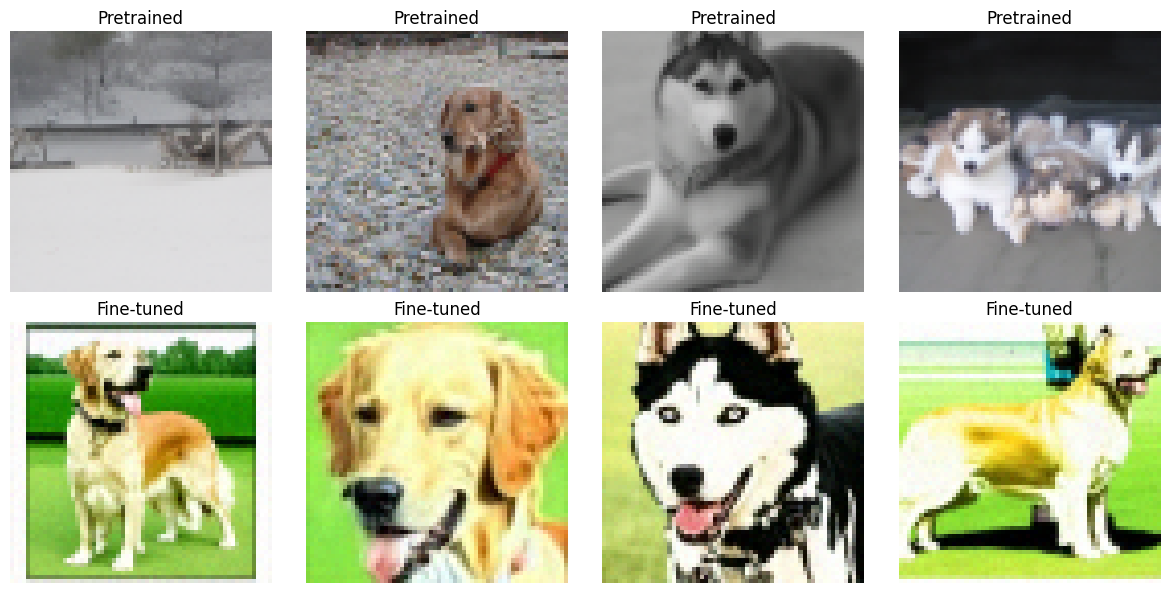

In [ ]:
# --- Setup & Weights ---
MODELS_DIR = "./models"
os.makedirs(MODELS_DIR, exist_ok=True)
WEIGHTS_PATH = f"{MODELS_DIR}/64x64_diffusion.pt"

if not os.path.exists(WEIGHTS_PATH):
    print("Downloading pretrained weights...")
    try:
        urllib.request.urlretrieve(
            "https://openaipublic.blob.core.windows.net/diffusion/jul-2021/64x64_diffusion.pt",
            WEIGHTS_PATH
        )
        print(f"Weights saved to: {WEIGHTS_PATH}")
    except Exception as e:
        print(f"Download failed: {e}")


# --- Configuration ---
@dataclass
class Config:
    DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"
    SEED: int = 123

    RUN_DIR: str = "./ddgan_run"
    CHECKPOINT_PATH: str = "./ddgan_run/saved_checkpoint.pt"
    START_NEW_RUN: bool = True

    TRAIN_OPTIM_STEPS_THIS_RUN: int = 1000
    IMAGE_SIZE: int = 64
    NUM_CLASSES: int = 1000
    BATCH_SIZE: int = 32
    LR_G: float = 5e-6
    LR_D: float = 4e-5
    WEIGHT_DECAY_G: float = 0.0
    WEIGHT_DECAY_D: float = 0.0
    GRAD_CLIP_NORM: float = 1.0
    LOG_EVERY: int = 10
    SAVE_EVERY: int = 100

    TARGET_CLASSES: List[int] = None  # defaults to [207, 250]
    MAX_SAMPLES_PER_CLASS: Optional[int] = 500
    NUM_WORKERS: int = 0
    SHUFFLE: bool = True

    DIFFUSION_BASE_STEPS: int = 1000
    DIFFUSION_RESPACING: str = "100"
    USE_FP16: bool = False

    LAMBDA_ADV: float = 0.002
    ADV_GUIDANCE_REGION: float = 0.5
    D_UPDATES_PER_G: int = 2

    REC_ADV_RAMP_SCHEDULE: bool = True
    ADV_RAMP_STEPS: int = 1000

    EVAL_NUM_IMAGES: int = 4
    EVAL_SAVE_PATH: str = "./ddgan_run/eval_grid.png"

    REC_FREEZE_D_BACKBONE_BN_STATS: bool = True
    REC_USE_P_MEAN_VARIANCE_PRED_XSTART: bool = True
    PRETRAINED_DIFFUSION_WEIGHTS = WEIGHTS_PATH

cfg = Config()
if cfg.TARGET_CLASSES is None:
    cfg.TARGET_CLASSES = [207, 250]  # Golden Retriever & Siberian Husky

os.makedirs(cfg.RUN_DIR, exist_ok=True)
os.makedirs(os.path.join(cfg.RUN_DIR, "models"), exist_ok=True)

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(cfg.SEED)

if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print(f"=== CONFIG ===\nSteps: {cfg.TRAIN_OPTIM_STEPS_THIS_RUN} | Lambda: {cfg.LAMBDA_ADV} | Ramp: {cfg.ADV_RAMP_STEPS}")


# --- Dataset ---
def aggressive_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("Loading Dataset...")
full_ds = load_dataset("benjamin-paine/imagenet-1k-64x64", split="train")
target_set = set(cfg.TARGET_CLASSES)
filtered_ds = full_ds.filter(lambda x: int(x["label"]) in target_set)

if cfg.MAX_SAMPLES_PER_CLASS is not None:
    counts = {c: 0 for c in cfg.TARGET_CLASSES}
    indices = []
    for i in range(len(filtered_ds)):
        lbl = int(filtered_ds[i]["label"])
        if counts[lbl] < cfg.MAX_SAMPLES_PER_CLASS:
            indices.append(i)
            counts[lbl] += 1
    filtered_ds = filtered_ds.select(indices)

print(f"Dataset Size: {len(filtered_ds)} images.")

def collate_fn(batch):
    imgs, labels = [], []
    for ex in batch:
        x = torch.from_numpy(np.array(ex["image"], dtype=np.uint8)).permute(2, 0, 1).float() / 255.0
        x = x * 2.0 - 1.0  # normalize to [-1, 1]
        imgs.append(x)
        labels.append(int(ex["label"]))
    return torch.stack(imgs, dim=0), torch.tensor(labels, dtype=torch.long)

loader = DataLoader(filtered_ds, batch_size=cfg.BATCH_SIZE, shuffle=cfg.SHUFFLE, collate_fn=collate_fn)


# --- Models ---
class ConditionalResNet18(nn.Module):
    def __init__(self, num_classes=1000, embed_dim=128):
        super().__init__()
        self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Identity()
        self.class_emb = nn.Embedding(num_classes, embed_dim)
        self.head = nn.Sequential(
            nn.Linear(512 + embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, x, labels):
        x = (x + 1.0) / 2.0
        x = (x - self.mean) / self.std
        feats = self.backbone(x)
        emb = self.class_emb(labels)
        return self.head(torch.cat([feats, emb], dim=1)).squeeze(1)

D = ConditionalResNet18(num_classes=1000).to(cfg.DEVICE).float()
for p in D.backbone.parameters():
    p.requires_grad_(False)

diffusion_args = script_util.model_and_diffusion_defaults()
diffusion_args.update({
    "image_size": 64,
    "num_channels": 192,
    "num_res_blocks": 3,
    "learn_sigma": True,
    "class_cond": True,
    "use_checkpoint": True,
    "attention_resolutions": "32,16,8",
    "num_heads": 4,
    "num_head_channels": 64,
    "use_scale_shift_norm": True,
    "dropout": 0.1,
    "resblock_updown": True,
    "use_fp16": cfg.USE_FP16,
    "use_new_attention_order": True,
    "diffusion_steps": cfg.DIFFUSION_BASE_STEPS,
    "noise_schedule": "cosine",
    "timestep_respacing": cfg.DIFFUSION_RESPACING,
    "channel_mult": "1,2,3,4",
    "num_heads_upsample": -1,
    "use_kl": False,
    "predict_xstart": False,
    "rescale_timesteps": True,
    "rescale_learned_sigmas": False,
})

G, diffusion = script_util.create_model_and_diffusion(**diffusion_args)
G.to(cfg.DEVICE).float()

print("Loading pretrained weights...")
ckpt = torch.load(cfg.PRETRAINED_DIFFUSION_WEIGHTS, map_location="cpu")

def _extract_state_dict(obj):
    if isinstance(obj, dict):
        return obj.get("ema") or obj.get("state_dict") or obj.get("model") or obj
    return obj

G.load_state_dict(_extract_state_dict(ckpt), strict=False)
print("Weights loaded.")


# --- Optimizers & Checkpoints ---
opt_G = torch.optim.AdamW(G.parameters(), lr=cfg.LR_G)
opt_D = torch.optim.AdamW(filter(lambda p: p.requires_grad, D.parameters()), lr=cfg.LR_D)

def save_checkpoint(step, G, D, opt_G, opt_D):
    path = cfg.CHECKPOINT_PATH
    ckpt = {
        "step": step, "G_state": G.state_dict(), "D_state": D.state_dict(),
        "opt_G_state": opt_G.state_dict(), "opt_D_state": opt_D.state_dict(), "cfg": asdict(cfg)
    }
    tmp_path = path + ".tmp"
    torch.save(ckpt, tmp_path)
    if os.path.exists(path):
        os.remove(path)
    os.rename(tmp_path, path)

global_step = 0
if cfg.START_NEW_RUN and os.path.exists(cfg.CHECKPOINT_PATH):
    print("Starting new run — deleting old checkpoint.")
    os.remove(cfg.CHECKPOINT_PATH)
elif os.path.exists(cfg.CHECKPOINT_PATH):
    try:
        ckpt = torch.load(cfg.CHECKPOINT_PATH, map_location=cfg.DEVICE)
        global_step = ckpt["step"]
        G.load_state_dict(ckpt["G_state"])
        D.load_state_dict(ckpt["D_state"])
        print(f"Resumed from step {global_step}")
    except Exception:
        print("Checkpoint corrupted — starting fresh.")


# --- Phase 1: Discriminator Warm-up ---
print("Phase 1: Warming up Discriminator with frozen Generator...")

G.eval()
for p in G.parameters():
    p.requires_grad_(False)

UNFREEZE_D_BACKBONE = False

if UNFREEZE_D_BACKBONE:
    for p in D.backbone.parameters():
        p.requires_grad_(True)
    opt_D_warmup = torch.optim.AdamW(D.parameters(), lr=cfg.LR_D)
else:
    print("   Keeping D backbone frozen...")
    opt_D_warmup = opt_D

D.train()
if cfg.REC_FREEZE_D_BACKBONE_BN_STATS:
    D.backbone.eval()

bce = nn.BCEWithLogitsLoss()

def get_pred_xstart_warmup(x_t, t, y):
    out = diffusion.p_mean_variance(G, x_t, t, model_kwargs={"y": y})
    return out["pred_xstart"].clamp(-1, 1)

WARMUP_STEPS = 500
warmup_history = {'step': [], 'd_loss': [], 'd_real': [], 'd_fake': []}

data_iter = iter(loader)
progress = tqdm(total=WARMUP_STEPS, desc="D Warm-up")

for step in range(WARMUP_STEPS):
    try:
        real_x, y = next(data_iter)
    except StopIteration:
        data_iter = iter(loader)
        real_x, y = next(data_iter)

    real_x, y = real_x.to(cfg.DEVICE), y.to(cfg.DEVICE)
    t = torch.randint(0, int(diffusion.num_timesteps), (real_x.shape[0],), device=cfg.DEVICE)
    noise = torch.randn_like(real_x)
    x_t = diffusion.q_sample(real_x, t, noise=noise)

    with torch.no_grad():
        fake_x0 = get_pred_xstart_warmup(x_t, t, y)

    real_logits = D(real_x, y)
    fake_logits = D(fake_x0, y)

    d_loss = bce(real_logits, torch.ones_like(real_logits)) + bce(fake_logits, torch.zeros_like(fake_logits))

    opt_D_warmup.zero_grad()
    d_loss.backward()
    opt_D_warmup.step()

    warmup_history['step'].append(step)
    warmup_history['d_loss'].append(d_loss.item())
    warmup_history['d_real'].append(torch.sigmoid(real_logits).mean().item())
    warmup_history['d_fake'].append(torch.sigmoid(fake_logits).mean().item())

    if step % 50 == 0:
        progress.set_description(
            f"D_loss={d_loss.item():.3f} | Real={warmup_history['d_real'][-1]:.2f} | Fake={warmup_history['d_fake'][-1]:.2f}"
        )
    progress.update(1)

progress.close()

print("\nPhase 1 Complete!")
print(f"   Final D scores — Real: {warmup_history['d_real'][-1]:.3f}, Fake: {warmup_history['d_fake'][-1]:.3f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(warmup_history['step'], warmup_history['d_loss'])
ax1.set_title("D Loss during Warm-up")
ax1.set_xlabel("Step"); ax1.set_ylabel("Loss")
ax1.grid(True, alpha=0.3)

ax2.plot(warmup_history['step'], warmup_history['d_real'], label='Real → D')
ax2.plot(warmup_history['step'], warmup_history['d_fake'], label='Fake → D')
ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax2.set_title("D Predictions during Warm-up")
ax2.set_xlabel("Step"); ax2.set_ylabel("Sigmoid(logit)")
ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

for p in G.parameters():
    p.requires_grad_(True)
G.train()

if UNFREEZE_D_BACKBONE:
    for p in D.backbone.parameters():
        p.requires_grad_(False)
    opt_D = torch.optim.AdamW(filter(lambda p: p.requires_grad, D.parameters()), lr=cfg.LR_D)

del warmup_history, data_iter, progress
try:
    del opt_D_warmup
except NameError:
    pass

gc.collect()
torch.cuda.empty_cache()
print(f"\nMemory cleaned. Free GPU: {torch.cuda.mem_get_info()[0] / 1024**3:.2f} GB")
print("Ready for Phase 2...")


# --- Phase 2: Main Training Loop ---
print(f"\nStarting training for {cfg.TRAIN_OPTIM_STEPS_THIS_RUN} steps...")
G.train()
D.train()
D.backbone.eval()
bce = nn.BCEWithLogitsLoss()

real_history = {'step': [], 'd_loss': [], 'g_diff': [], 'g_adv': [], 'lambda': []}

def adv_weight_for_step(step):
    if cfg.ADV_RAMP_STEPS <= 0:
        return cfg.LAMBDA_ADV
    return cfg.LAMBDA_ADV * min(step / cfg.ADV_RAMP_STEPS, 1.0)

def get_pred_xstart(x_t, t, y):
    if cfg.REC_USE_P_MEAN_VARIANCE_PRED_XSTART:
        out = diffusion.p_mean_variance(G, x_t, t, model_kwargs={"y": y})
        return out["pred_xstart"].clamp(-1, 1)
    else:
        out = G(x_t, t, y=y)
        eps, _ = torch.split(out, 3, dim=1)
        return diffusion._predict_xstart_from_eps(x_t, t, eps).clamp(-1, 1)

progress = tqdm(total=cfg.TRAIN_OPTIM_STEPS_THIS_RUN, initial=0)
data_iter = iter(loader)
steps_done = 0

while steps_done < cfg.TRAIN_OPTIM_STEPS_THIS_RUN:
    try:
        real_x, y = next(data_iter)
    except StopIteration:
        data_iter = iter(loader)
        real_x, y = next(data_iter)

    real_x, y = real_x.to(cfg.DEVICE), y.to(cfg.DEVICE)
    t = torch.randint(0, int(diffusion.num_timesteps), (real_x.shape[0],), device=cfg.DEVICE)
    noise = torch.randn_like(real_x)
    x_t = diffusion.q_sample(real_x, t, noise=noise)

    # Train Discriminator
    with torch.no_grad():
        fake_x0 = get_pred_xstart(x_t, t, y)

    real_logits = D(real_x, y)
    fake_logits = D(fake_x0.detach(), y)
    d_loss = bce(real_logits, torch.ones_like(real_logits)) + bce(fake_logits, torch.zeros_like(fake_logits))

    opt_D.zero_grad()
    d_loss.backward()
    opt_D.step()

    # Train Generator
    model_output = G(x_t, t, y=y)
    eps_pred, _ = torch.split(model_output, 3, dim=1)
    diff_loss = F.mse_loss(eps_pred, noise)

    T_max = max(int(diffusion.num_timesteps), 2)
    adv_on = (t.float().mean().item() / (T_max - 1)) <= cfg.ADV_GUIDANCE_REGION

    loss_adv = torch.tensor(0.0, device=cfg.DEVICE)
    if adv_on:
        fake_x0_g = get_pred_xstart(x_t, t, y)
        fake_logits_g = D(fake_x0_g, y)
        loss_adv = bce(fake_logits_g, torch.ones_like(fake_logits_g))

    lam = adv_weight_for_step(global_step)
    total_g_loss = diff_loss + lam * loss_adv

    opt_G.zero_grad()
    total_g_loss.backward()
    opt_G.step()

    real_history['step'].append(global_step)
    real_history['d_loss'].append(d_loss.item())
    real_history['g_diff'].append(diff_loss.item())
    real_history['g_adv'].append(loss_adv.item() if torch.is_tensor(loss_adv) else loss_adv)
    real_history['lambda'].append(lam)

    global_step += 1
    steps_done += 1
    progress.update(1)

    if steps_done % cfg.LOG_EVERY == 0:
        progress.set_description(f"D={d_loss.item():.3f} G={diff_loss.item():.3f} L={lam:.4f}")

    if global_step % cfg.SAVE_EVERY == 0:
        save_checkpoint(global_step, G, D, opt_G, opt_D)

    if steps_done % 50 == 0:
        aggressive_cleanup()

progress.close()
save_checkpoint(global_step, G, D, opt_G, opt_D)
print("Training complete.")


# --- Visual Comparison ---
print("\nGenerating comparison images...")

@torch.no_grad()
def quick_sample(model, steps="50", n=4):
    args = dict(diffusion_args)
    args["timestep_respacing"] = steps
    _, diff = script_util.create_model_and_diffusion(**args)

    y = torch.tensor(cfg.TARGET_CLASSES, device=cfg.DEVICE)
    y = y[torch.randint(0, len(y), (n,), device=cfg.DEVICE)]
    noise = torch.randn(n, 3, 64, 64, device=cfg.DEVICE)

    model.eval()
    samples = diff.p_sample_loop(model, (n, 3, 64, 64), noise=noise, model_kwargs={"y": y}, progress=True)
    return samples.clamp(-1, 1).cpu()

base_G, _ = script_util.create_model_and_diffusion(**diffusion_args)
base_G.to(cfg.DEVICE).eval()
base_G.load_state_dict(_extract_state_dict(torch.load(cfg.PRETRAINED_DIFFUSION_WEIGHTS, map_location="cpu")))

print("Sampling pretrained model...")
base_imgs = quick_sample(base_G)
print("Sampling fine-tuned model...")
curr_imgs = quick_sample(G)

fig, ax = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    ax[0, i].imshow(((base_imgs[i] + 1) / 2).permute(1, 2, 0))
    ax[0, i].set_title("Pretrained"); ax[0, i].axis("off")
    ax[1, i].imshow(((curr_imgs[i] + 1) / 2).permute(1, 2, 0))
    ax[1, i].set_title("Fine-tuned"); ax[1, i].axis("off")
plt.tight_layout()
plt.savefig(cfg.EVAL_SAVE_PATH)
plt.show()

In [ ]:
def get_weights_path(cfg):
    if hasattr(cfg, "PRETRAINED_DIFFUSION_WEIGHTS"):
        return cfg.PRETRAINED_DIFFUSION_WEIGHTS
    return "./models/64x64_diffusion.pt"

def get_diffusion_defaults(respacing="50"):
    defaults = script_util.model_and_diffusion_defaults()
    defaults.update({
        "image_size": 64,
        "num_channels": 192,
        "num_res_blocks": 3,
        "learn_sigma": True,
        "class_cond": True,
        "use_checkpoint": True,
        "attention_resolutions": "32,16,8",
        "num_heads": 4,
        "num_head_channels": 64,
        "use_scale_shift_norm": True,
        "dropout": 0.1,
        "resblock_updown": True,
        "use_fp16": False,
        "use_new_attention_order": True,
        "diffusion_steps": 1000,
        "timestep_respacing": respacing,
        "channel_mult": "1,2,3,4"
    })
    return defaults

def build_eval_diffusion(eval_respacing="50"):
    _, eval_diffusion = script_util.create_model_and_diffusion(**get_diffusion_defaults(eval_respacing))
    return eval_diffusion

def build_eval_model_from_pretrained(eval_respacing="50"):
    base_G, _ = script_util.create_model_and_diffusion(**get_diffusion_defaults(eval_respacing))
    base_G.to(cfg.DEVICE)

    w_path = get_weights_path(cfg)
    print(f"Loading pretrained weights from: {w_path}")

    if os.path.exists(w_path):
        ckpt = torch.load(w_path, map_location="cpu")
        base_G.load_state_dict(_extract_state_dict(ckpt), strict=False)
    else:
        print(f"Warning: weights not found at {w_path}. Model is randomly initialized.")

    base_G.eval()
    return base_G

def sample_images_with_eval_diffusion(model, eval_diffusion, y, noise):
    model.eval()
    samples = eval_diffusion.p_sample_loop(
        model,
        shape=noise.shape,
        noise=noise,
        clip_denoised=True,
        model_kwargs={"y": y},
        progress=True,
        device=cfg.DEVICE
    )
    return samples.clamp(-1, 1)

@torch.no_grad()
def smart_empirical_comparison(n_tests=32):
    print(f"Running discriminator evaluation on {n_tests} images...")

    G.eval()
    D.eval()

    eval_diffusion = build_eval_diffusion(eval_respacing="50")

    # Real images
    print("[1/3] Sampling real images...")
    real_scores = []
    collected_labels = []
    needed = n_tests
    data_iter = iter(loader)

    while needed > 0:
        try:
            x, y = next(data_iter)
        except StopIteration:
            data_iter = iter(loader)
            x, y = next(data_iter)

        take = min(x.size(0), needed)
        x_batch = x[:take].to(cfg.DEVICE)
        y_batch = y[:take].to(cfg.DEVICE)

        real_scores.append(torch.sigmoid(D(x_batch, y_batch)).mean().item())
        collected_labels.append(y_batch)
        needed -= take

    avg_real = sum(real_scores) / len(real_scores)
    labels = torch.cat(collected_labels, dim=0)[:n_tests]
    noise = torch.randn(n_tests, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, device=cfg.DEVICE)

    # Pretrained model
    print("[2/3] Sampling from pretrained model...")
    base_G = build_eval_model_from_pretrained(eval_respacing="50")
    base_samples = sample_images_with_eval_diffusion(base_G, eval_diffusion, labels, noise)
    avg_base = torch.sigmoid(D(base_samples, labels)).mean().item()

    del base_G
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Fine-tuned model
    print("[3/3] Sampling from fine-tuned model...")
    curr_samples = sample_images_with_eval_diffusion(G, eval_diffusion, labels, noise)
    avg_curr = torch.sigmoid(D(curr_samples, labels)).mean().item()

    print("\n" + "=" * 50)
    print("Discriminator scores (0.0 = fake, 1.0 = real):")
    print("=" * 50)

    df = pd.DataFrame({
        "Source": ["Real Images", "Fine-Tuned Model", "Pretrained Model"],
        "Score": [avg_real, avg_curr, avg_base]
    })
    print(df)
    print("-" * 50)

    if avg_curr > avg_base:
        diff = (avg_curr - avg_base) / avg_base * 100
        print(f"Improvement: +{diff:.1f}% realism over pretrained baseline.")
    else:
        print("No improvement in discriminator score over pretrained baseline.")

smart_empirical_comparison(n_tests=32)

Running discriminator evaluation on 32 images...
[1/3] Sampling real images...
[2/3] Sampling from pretrained model...
Loading pretrained weights from: ./models/64x64_diffusion.pt


  0%|          | 0/50 [00:00<?, ?it/s]

[3/3] Sampling from fine-tuned model...


  0%|          | 0/50 [00:00<?, ?it/s]


Discriminator scores (0.0 = fake, 1.0 = real):
             Source     Score
0       Real Images  0.524506
1  Fine-Tuned Model  0.301977
2  Pretrained Model  0.080058
--------------------------------------------------
Improvement: +277.2% realism over pretrained baseline.


Starting final evaluation on 100 images...
[1/4] Loading models...
   Loading pretrained weights from: ./models/64x64_diffusion.pt
   Loaded: 541 tensors (541/541), missing: 0, unexpected: 0
[2/4] Generating samples...


  0%|          | 0/100 [00:00<?, ?it/s]


[3/4] Visual results...


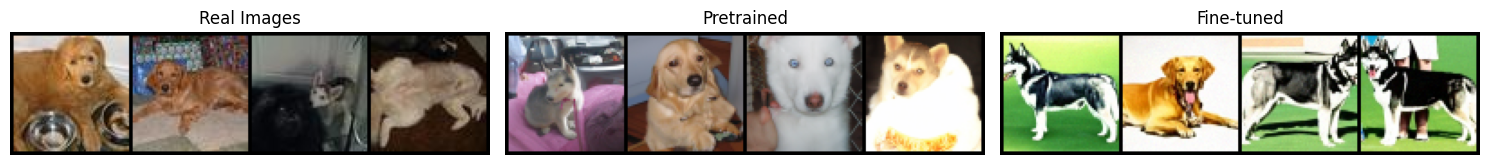

[4/4] Calculating metrics...

Metric          | Pretrained   | Fine-tuned   | Change
------------------------------------------------------------
Sharpness       | 0.0355       | 0.1385       | +289.6%
Precision       | 0.4200       | 0.2800       | -33.3%
Recall             | 0.1400       | 0.0300       | -78.6%


In [ ]:
TARGET_N = 100
BATCH_SIZE = 10

eval_diffusion = diffusion
G = G.to(cfg.DEVICE).eval()

print(f"Starting final evaluation on {TARGET_N} images...")

# Load base_G by cloning G to guarantee architecture match
print("[1/4] Loading models...")

def smart_load(model, raw_sd):
    model_sd = model.state_dict()
    stripped = {}
    for k, v in raw_sd.items():
        for p in ["module.", "ema.", "model.", "diffusion_model."]:
            if k.startswith(p):
                k = k[len(p):]
        stripped[k] = v

    matched = {
        k: v for k, v in stripped.items()
        if k in model_sd and hasattr(v, "shape") and v.shape == model_sd[k].shape
    }
    missing, unexpected = model.load_state_dict(matched, strict=False)
    loaded = len(model_sd) - len(missing)
    print(f"   Loaded: {len(matched)} tensors ({loaded}/{len(model_sd)}), missing: {len(missing)}, unexpected: {len(unexpected)}")
    if loaded < 0.8 * len(model_sd):
        print(f"   Warning: loaded <80% of weights. First missing keys: {list(missing)[:5]}")

base_G = copy.deepcopy(G).to(cfg.DEVICE).eval()
w_path = get_weights_path(cfg)
print(f"   Loading pretrained weights from: {w_path}")

if not os.path.exists(w_path):
    raise FileNotFoundError(f"Weights file not found: {w_path}")

ckpt = torch.load(w_path, map_location="cpu")
smart_load(base_G, _extract_state_dict(ckpt))

# Collect real images & generate samples
print("[2/4] Generating samples...")

real_imgs = []
got = 0
data_iter = iter(loader)
while got < TARGET_N:
    try:
        xb, _ = next(data_iter)
    except StopIteration:
        data_iter = iter(loader)
        xb, _ = next(data_iter)
    take = min(xb.size(0), TARGET_N - got)
    real_imgs.append(xb[:take].cpu())
    got += take

real_imgs = torch.cat(real_imgs, dim=0)[:TARGET_N]

fake_pre, fake_ft = [], []
generated = 0
pbar = tqdm(total=TARGET_N)
targets = torch.tensor(cfg.TARGET_CLASSES, device=cfg.DEVICE)

while generated < TARGET_N:
    curr_bs = min(BATCH_SIZE, TARGET_N - generated)
    labels = targets[torch.randint(0, len(targets), (curr_bs,), device=cfg.DEVICE)]
    noise = torch.randn(curr_bs, 3, 64, 64, device=cfg.DEVICE)

    with torch.no_grad():
        out_pre = eval_diffusion.p_sample_loop(
            base_G, shape=noise.shape, noise=noise, clip_denoised=True,
            model_kwargs={"y": labels}, progress=False, device=cfg.DEVICE
        ).clamp(-1, 1)
        fake_pre.append(ensure_nchw(out_pre))

        out_ft = eval_diffusion.p_sample_loop(
            G, shape=noise.shape, noise=noise, clip_denoised=True,
            model_kwargs={"y": labels}, progress=False, device=cfg.DEVICE
        ).clamp(-1, 1)
        fake_ft.append(ensure_nchw(out_ft))

    generated += curr_bs
    pbar.update(curr_bs)

pbar.close()
fake_pretrained = torch.cat(fake_pre, dim=0)
fake_finetuned  = torch.cat(fake_ft, dim=0)

gc.collect()
torch.cuda.empty_cache()

# Visual check
print("\n[3/4] Visual results...")

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); show_grid(real_imgs, "Real Images")
plt.subplot(1, 3, 2); show_grid(fake_pretrained, "Pretrained")
plt.subplot(1, 3, 3); show_grid(fake_finetuned, "Fine-tuned")
plt.tight_layout()
plt.show()

# Metrics
print("[4/4] Calculating metrics...")

s_pre = laplacian_variance(to_01(fake_pretrained))
s_ft  = laplacian_variance(to_01(fake_finetuned))
p_pre, r_pre = compute_pr_metrics(real_imgs, fake_pretrained)
p_ft,  r_ft  = compute_pr_metrics(real_imgs, fake_finetuned)

def pct_change(new, old, eps=1e-6):
    return ((new - old) / (abs(old) + eps)) * 100

print("\n" + "=" * 60)
print(f"{'Metric':<15} | {'Pretrained':<12} | {'Fine-tuned':<12} | {'Change'}")
print("-" * 60)
print(f"{'Sharpness':<15} | {s_pre:.4f}       | {s_ft:.4f}       | {pct_change(s_ft,  s_pre):+.1f}%")
print(f"{'Precision':<15} | {p_pre:.4f}       | {p_ft:.4f}       | {pct_change(p_ft,  p_pre):+.1f}%")
print(f"{'Recall':<15}    | {r_pre:.4f}       | {r_ft:.4f}       | {pct_change(r_ft,  r_pre):+.1f}%")
print("=" * 60)